In [ ]:
import os
import json
import math
import random
import time
import re
import pathlib
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from dataclasses import dataclass
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit # CRITICAL for patient split

from google.colab import drive

In [ ]:
import zipfile
import os
from google.colab import drive

# 1. Mount Drive (if not already mounted)
drive.mount('/content/drive')

# 2. Define Paths
# Check which zip name you have in your Drive folder
zip_path_v1 = "/content/drive/MyDrive/ML Project/Clean_Split_Dataset.zip"
zip_path_v2 = "/content/drive/MyDrive/ML Project/Clean_Split_Dataset_Final.zip"

extract_to = "/content/via_dataset_fixed"

# 3. Check and Unzip
if os.path.exists(zip_path_v2):
    target_zip = zip_path_v2
    print(f"Found latest dataset: {target_zip}")
elif os.path.exists(zip_path_v1):
    target_zip = zip_path_v1
    print(f"Found dataset: {target_zip}")
else:
    target_zip = None
    print("ERROR: Could not find the processed dataset zip in your Drive.")
    print("Please re-run the 'Data Preparation' (Splitting & Augmentation) script.")

if target_zip:
    print(f"Unzipping to {extract_to}...")
    with zipfile.ZipFile(target_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Success! Data restored. You can now run the training script.")

    # Verify the folder structure
    if os.path.exists(os.path.join(extract_to, 'train')):
        print("Verified: 'train' folder exists.")
    else:
        # Sometimes zip files have nested folders, let's fix that if it happens
        print("Checking for nested folders...")
        for root, dirs, files in os.walk(extract_to):
            if 'train' in dirs:
                nested_path = os.path.join(root, 'train')
                print(f"Found nested train folder at: {nested_path}")
                # You might need to update CFG.TRAIN_DIR in the training script to this path
                print(f"Update your CFG.TRAIN_DIR to: {nested_path}")

Mounted at /content/drive
Found latest dataset: /content/drive/MyDrive/ML Project/Clean_Split_Dataset_Final.zip
Unzipping to /content/via_dataset_fixed...
Success! Data restored. You can now run the training script.
Verified: 'train' folder exists.


In [ ]:
# 1. Setup & Config
# -----------------
@dataclass
class CFG:
    # Path to the NEW split dataset you just created
    TRAIN_DIR = r"/content/via_dataset_fixed/train"
    TEST_DIR =  r"/content/via_dataset_fixed/test"

    # Path to your original labels CSV (needed to map filename -> class)
    CSV_PATH  = "/content/drive/MyDrive/ML Project/labels_combine.csv"

    NUM_CLASSES: int = 3
    IMAGE_SIZE: int = 384
    BATCH_SIZE: int = 32
    EPOCHS: int = 30
    LR: float = 1e-4
    WD: float = 1e-2
    SEED: int = 42
    MODEL_NAME: str = "efficientnet_b0"
    LOSS: str = "cross_entropy"
    OUT_DIR: str = "runs"

cfg = CFG()

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(cfg.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 2. Data Preparation Logic (THE BIG FIX)
# ---------------------------------------
def prepare_dataframes():
    """
    Scans the new folders, cleans filenames to find original keys,
    and maps them to labels from the master CSV.
    """
    # 1. Load Master Labels
    master_df = pd.read_csv(cfg.CSV_PATH)

    # Clean up column names/values if necessary
    # Assumes CSV has columns: 'File' (or image_path) and 'class'
    # We create a dictionary: { '1AFC1.jpg': 'Precancer', ... }

    # Normalize the filename column in CSV to be just the basename
    if 'image_path' in master_df.columns:
        master_df['filename_key'] = master_df['image_path'].apply(lambda x: os.path.basename(str(x)))
    elif 'File' in master_df.columns:
        master_df['filename_key'] = master_df['File'].apply(lambda x: os.path.basename(str(x)))
    else:
        raise ValueError("CSV must have 'image_path' or 'File' column")

    label_map = dict(zip(master_df['filename_key'], master_df['class']))

    # 2. Helper to scan a folder and build a DF
    def scan_folder(folder_path):
        data = []
        files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

        for f in files:
            # Logic: '1AFC1_rot.jpg' -> Original Key: '1AFC1.jpg'
            # Remove augmentation suffixes to find the label key
            base_name = f

            # Regex to strip _rot, _blur, _radial, etc.
            # Looks for the LAST occurrence of .jpg
            clean_name = re.sub(r'_(rot|blur|bright|dark|trans|shear|radial|h_flip).*', '', Path(f).stem)
            original_key = f"{clean_name}.jpg"

            # Parse Patient ID for splitting (e.g., 1AFC from 1AFC1.jpg)
            # Adjust regex based on your file format (Number+Letters or Letters+Number)
            # Trying robust search:
            match = re.search(r"([0-9]+[A-Z]+|[A-Z]+[0-9]+)", clean_name)
            patient_id = match.group(0) if match else "Unknown"

            if original_key in label_map:
                label = label_map[original_key]
                data.append({
                    "path": os.path.join(folder_path, f),
                    "label": label,
                    "patient_id": patient_id, # critical for GroupSplit
                    "is_aug": (f != original_key)
                })
            else:
                # Fallback: sometimes the key might be exact match
                pass

        return pd.DataFrame(data)

    print("Scanning Training Directory...")
    train_full_df = scan_folder(cfg.TRAIN_DIR)
    print(f"Found {len(train_full_df)} training images (including augmentations).")

    print("Scanning Test Directory...")
    test_df = scan_folder(cfg.TEST_DIR)
    print(f"Found {len(test_df)} test images.")

    # 3. Map String Labels to Int
    mapping = {"Normal": 0, "Precancer": 1, "Cancer": 2}

    # Handle cases where CSV might already have numbers or different strings
    def map_label(x):
        if isinstance(x, int): return x
        return mapping.get(x, -1) # Returns -1 if not found

    train_full_df['class_num'] = train_full_df['label'].apply(map_label)
    test_df['class_num'] = test_df['label'].apply(map_label)

    # Filter out bad labels
    train_full_df = train_full_df[train_full_df['class_num'] != -1]
    test_df = test_df[test_df['class_num'] != -1]

    # 4. Patient-Aware Validation Split
    # We split the TRAIN folder into Train/Val, but strictly by PATIENT ID
    # This prevents '1AFC1_rot.jpg' being in Train and '1AFC1.jpg' in Val
    gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=cfg.SEED)

    train_idx, val_idx = next(gss.split(train_full_df, groups=train_full_df['patient_id']))

    train_df = train_full_df.iloc[train_idx].reset_index(drop=True)
    val_df = train_full_df.iloc[val_idx].reset_index(drop=True)

    print("-" * 30)
    print(f"Final Train Size: {len(train_df)} (Augmented)")
    print(f"Final Val Size:   {len(val_df)} (Augmented subset)")
    print(f"Final Test Size:  {len(test_df)} (Original only)")
    print("-" * 30)

    return train_df, val_df, test_df

In [ ]:
# 3. Dataset Class
# ----------------
clip_limit = 13
class CervicalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        label = row['class_num']

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# 4. Transforms
# Define a custom CLAHE transform class
class ApplyCLAHE(object):
    def __init__(self, clip_limit=clip_limit, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        # Convert PIL to Numpy
        img_np = np.array(img)

        # Convert RGB to LAB color space (L = Lightness)
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to the L-channel only (contrast)
        cl = self.clahe.apply(l)

        # Merge back
        limg = cv2.merge((cl, a, b))

        # Convert back to RGB
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        return Image.fromarray(final)

# Update your get_transforms
def get_transforms(image_size):
    train_tfms = T.Compose([
        ApplyCLAHE(clip_limit=clip_limit), # <--- ADD THIS FIRST
        T.Resize((image_size, image_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),    # Add vertical flip too (anatomy has no "up")
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    # Apply to Validation too so the model sees the same "enhanced" view
    val_tfms = T.Compose([
        ApplyCLAHE(clip_limit=clip_limit), # <--- ADD THIS
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return train_tfms, val_tfms

# 5. Training Loop Components
# ---------------------------
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    losses, accs = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        acc = (preds == y).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
    return np.mean(losses), np.mean(accs)

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    losses, accs, all_preds, all_targets = [], [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        preds = logits.argmax(1)

        losses.append(loss.item())
        accs.append((preds == y).float().mean().item())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    f1 = f1_score(all_targets, all_preds, average='macro')
    return np.mean(losses), np.mean(accs), f1, all_preds, all_targets

Scanning Training Directory...
Found 745 training images (including augmentations).
Scanning Test Directory...
Found 37 test images.
------------------------------
Final Train Size: 630 (Augmented)
Final Val Size:   115 (Augmented subset)
Final Test Size:  37 (Original only)
------------------------------
Class Counts: {0: 345, 1: 210, 2: 75}
Partial Unfreeze: Training 3,290,571 of 4,011,391 params.

Starting Training...
Epoch 01 | Train Loss: 1.1642 Acc: 0.683 | Val Loss: 2.3777 F1: 0.416
Epoch 02 | Train Loss: 0.6384 Acc: 0.843 | Val Loss: 1.7316 F1: 0.478
Epoch 03 | Train Loss: 0.5701 Acc: 0.870 | Val Loss: 1.5730 F1: 0.504
Epoch 04 | Train Loss: 0.4225 Acc: 0.937 | Val Loss: 1.4518 F1: 0.425
Epoch 05 | Train Loss: 0.4083 Acc: 0.930 | Val Loss: 1.3675 F1: 0.494
Epoch 06 | Train Loss: 0.3378 Acc: 0.964 | Val Loss: 1.3815 F1: 0.535
Epoch 07 | Train Loss: 0.3368 Acc: 0.959 | Val Loss: 1.2807 F1: 0.529
Epoch 08 | Train Loss: 0.3328 Acc: 0.970 | Val Loss: 1.3198 F1: 0.499
Epoch 09 | Trai

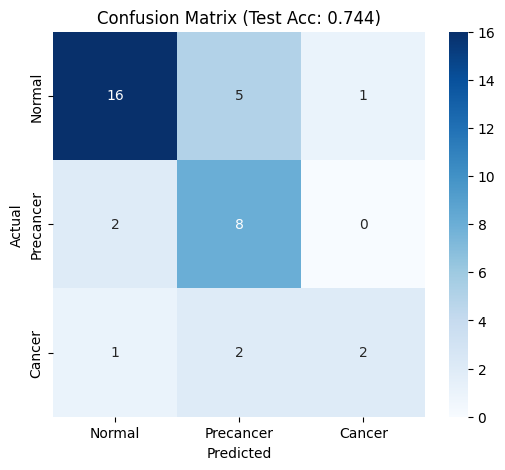

              precision    recall  f1-score   support

      Normal       0.84      0.73      0.78        22
   Precancer       0.53      0.80      0.64        10
      Cancer       0.67      0.40      0.50         5

    accuracy                           0.70        37
   macro avg       0.68      0.64      0.64        37
weighted avg       0.73      0.70      0.70        37



In [ ]:
# 6. Main Execution
# -----------------
def main():
    # A. Prepare Data
    train_df, val_df, test_df = prepare_dataframes()

    train_tfms, val_tfms = get_transforms(cfg.IMAGE_SIZE)

    train_ds = CervicalDataset(train_df, transform=train_tfms)
    val_ds = CervicalDataset(val_df, transform=val_tfms)
    test_ds = CervicalDataset(test_df, transform=val_tfms)

    # B. Weighted Sampler for Imbalance
    # Calculate weights based on Class counts in Training set
    class_counts = train_df['class_num'].value_counts().sort_index()
    print("Class Counts:", class_counts.to_dict())

    sample_weights = [1.0 / class_counts[label] for label in train_df['class_num']]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)

    # C. Model Setup (3-CLASS, PARTIAL UNFREEZE)
    # ------------------------------------------

    # 1. Create Model
    model = timm.create_model(cfg.MODEL_NAME, pretrained=True, num_classes=3) # Force 3 classes
    model = model.to(device)

    # 2. Intelligent Unfreezing (The "Goldilocks" Fix)
    # We freeze the first 60% (Generic shapes) and train the last 40% (Medical textures)

    # First, freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the Head (Classifier)
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Unfreeze the Last 3 Blocks of EfficientNet
    # These are the layers that see "patterns" and "textures"
    # (EfficientNet B0 has 7 blocks total)
    for param in model.blocks[-1].parameters(): # Block 6
        param.requires_grad = True
    for param in model.blocks[-2].parameters(): # Block 5
        param.requires_grad = True
    for param in model.blocks[-3].parameters(): # Block 4
        param.requires_grad = True

    # Check what we are training
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Partial Unfreeze: Training {trainable:,} of {total:,} params.")

    # 3. Loss Function Upgrade: Label Smoothing
    # Standard CrossEntropy forces the model to shout "100% CANCER!"
    # Label Smoothing tells it to say "90% Cancer, 10% Other", which reduces overfitting.
    from timm.loss import LabelSmoothingCrossEntropy

    # We still use class weights because of imbalance
    counts = train_df['class_num'].value_counts().sort_index()
    weights = torch.tensor([1.0/counts[0], 1.0/counts[1], 1.0/counts[2]], dtype=torch.float32).to(device)
    weights = weights / weights.sum()

    # Note: LabelSmoothing in timm usually doesn't take class weights directly,
    # so we often use standard CrossEntropy with label_smoothing arg if using PyTorch 1.10+,
    # OR we use the weighted approach. Let's stick to Weighted CE for now but add strong regularization.
    criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

    # 4. Optimizer
    # We use a smaller Learning Rate because we are training body layers now
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.02)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)

    # D. Training Loop
    out_dir = Path(cfg.OUT_DIR) / f"exp_{time.strftime('%m%d_%H%M')}"
    out_dir.mkdir(parents=True, exist_ok=True)

    best_f1 = -1.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    print("\nStarting Training...")
    for epoch in range(1, cfg.EPOCHS + 1):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        v_loss, v_acc, v_f1, _, _ = validate(model, val_loader, criterion)

        scheduler.step()

        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['val_f1'].append(v_f1)

        print(f"Epoch {epoch:02d} | Train Loss: {t_loss:.4f} Acc: {t_acc:.3f} | Val Loss: {v_loss:.4f} F1: {v_f1:.3f}")

        if v_f1 > best_f1:
            best_f1 = v_f1
            torch.save(model.state_dict(), out_dir / "best_model.pth")

    print(f"\nTraining Complete. Best Val F1: {best_f1:.3f}")

    # E. Final Test on Pure Unseen Data
    print("\nRunning Final Test on Clean Test Set...")
    model.load_state_dict(torch.load(out_dir / "best_model.pth"))
    test_loss, test_acc, test_f1, test_preds, test_targets = validate(model, test_loader, criterion)

    print(f"TEST RESULTS -> Acc: {test_acc:.3f} | F1: {test_f1:.3f}")

    # Save History
    json.dump(history, open(out_dir / "history.json", "w"))

    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # 1. Define the mapping explicitly
    mapping = {"Normal": 0, "Precancer": 1, "Cancer": 2}
    class_names = list(mapping.keys())

    # 2. Plot
    cm = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix (Test Acc: {test_acc:.3f})")
    plt.show()

    # 3. Print a report to see which class is killing you
    from sklearn.metrics import classification_report
    print(classification_report(test_targets, test_preds, target_names=class_names))
if __name__ == "__main__":
    main()

Scanning Training Directory...
Found 745 training images (including augmentations).
Scanning Test Directory...
Found 37 test images.
------------------------------
Final Train Size: 630 (Augmented)
Final Val Size:   115 (Augmented subset)
Final Test Size:  37 (Original only)
------------------------------
Class Counts: {0: 345, 1: 210, 2: 75}
Partial Unfreeze: Training 3,290,571 of 4,011,391 params.

Starting Training...
Epoch 01 | Train Loss: 1.1548 Acc: 0.688 | Val Loss: 2.0364 F1: 0.553
Epoch 02 | Train Loss: 0.6745 Acc: 0.839 | Val Loss: 1.7209 F1: 0.482
Epoch 03 | Train Loss: 0.4976 Acc: 0.869 | Val Loss: 1.4505 F1: 0.532
Epoch 04 | Train Loss: 0.4376 Acc: 0.912 | Val Loss: 1.4984 F1: 0.490
Epoch 05 | Train Loss: 0.3999 Acc: 0.949 | Val Loss: 1.2140 F1: 0.516
Epoch 06 | Train Loss: 0.3436 Acc: 0.954 | Val Loss: 1.0650 F1: 0.594
Epoch 07 | Train Loss: 0.3720 Acc: 0.960 | Val Loss: 1.0713 F1: 0.573
Epoch 08 | Train Loss: 0.3210 Acc: 0.980 | Val Loss: 1.1029 F1: 0.568
Epoch 09 | Trai

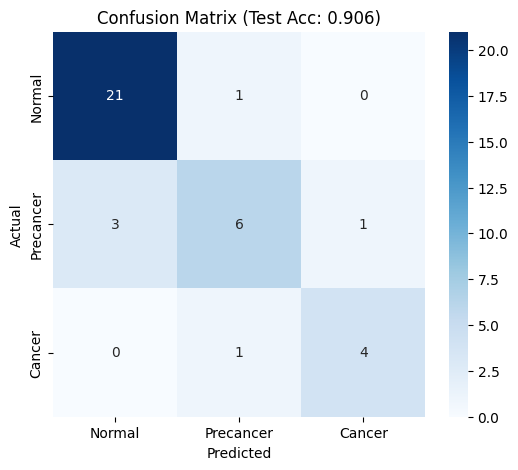

              precision    recall  f1-score   support

      Normal       0.88      0.95      0.91        22
   Precancer       0.75      0.60      0.67        10
      Cancer       0.80      0.80      0.80         5

    accuracy                           0.84        37
   macro avg       0.81      0.78      0.79        37
weighted avg       0.83      0.84      0.83        37



In [ ]:
# 6. Main Execution
# -----------------
def main():
    # A. Prepare Data
    train_df, val_df, test_df = prepare_dataframes()

    train_tfms, val_tfms = get_transforms(cfg.IMAGE_SIZE)

    train_ds = CervicalDataset(train_df, transform=train_tfms)
    val_ds = CervicalDataset(val_df, transform=val_tfms)
    test_ds = CervicalDataset(test_df, transform=val_tfms)

    # B. Weighted Sampler for Imbalance
    # Calculate weights based on Class counts in Training set
    class_counts = train_df['class_num'].value_counts().sort_index()
    print("Class Counts:", class_counts.to_dict())

    sample_weights = [1.0 / class_counts[label] for label in train_df['class_num']]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)

    # C. Model Setup (3-CLASS, PARTIAL UNFREEZE)
    # ------------------------------------------

    # 1. Create Model
    model = timm.create_model(cfg.MODEL_NAME, pretrained=True, num_classes=3) # Force 3 classes
    model = model.to(device)

    # 2. Intelligent Unfreezing (The "Goldilocks" Fix)
    # We freeze the first 60% (Generic shapes) and train the last 40% (Medical textures)

    # First, freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the Head (Classifier)
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Unfreeze the Last 3 Blocks of EfficientNet
    # These are the layers that see "patterns" and "textures"
    # (EfficientNet B0 has 7 blocks total)
    for param in model.blocks[-1].parameters(): # Block 6
        param.requires_grad = True
    for param in model.blocks[-2].parameters(): # Block 5
        param.requires_grad = True
    for param in model.blocks[-3].parameters(): # Block 4
        param.requires_grad = True

    # Check what we are training
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Partial Unfreeze: Training {trainable:,} of {total:,} params.")

    # 3. Loss Function Upgrade: Label Smoothing
    # Standard CrossEntropy forces the model to shout "100% CANCER!"
    # Label Smoothing tells it to say "90% Cancer, 10% Other", which reduces overfitting.
    from timm.loss import LabelSmoothingCrossEntropy

    # We still use class weights because of imbalance
    counts = train_df['class_num'].value_counts().sort_index()
    weights = torch.tensor([1.0/counts[0], 1.0/counts[1], 1.0/counts[2]], dtype=torch.float32).to(device)
    weights = weights / weights.sum()

    # Note: LabelSmoothing in timm usually doesn't take class weights directly,
    # so we often use standard CrossEntropy with label_smoothing arg if using PyTorch 1.10+,
    # OR we use the weighted approach. Let's stick to Weighted CE for now but add strong regularization.
    criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

    # 4. Optimizer
    # We use a smaller Learning Rate because we are training body layers now
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.02)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)

    # D. Training Loop
    out_dir = Path(cfg.OUT_DIR) / f"exp_{time.strftime('%m%d_%H%M')}"
    out_dir.mkdir(parents=True, exist_ok=True)

    best_f1 = -1.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    print("\nStarting Training...")
    for epoch in range(1, cfg.EPOCHS + 1):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        v_loss, v_acc, v_f1, _, _ = validate(model, val_loader, criterion)

        scheduler.step()

        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['val_f1'].append(v_f1)

        print(f"Epoch {epoch:02d} | Train Loss: {t_loss:.4f} Acc: {t_acc:.3f} | Val Loss: {v_loss:.4f} F1: {v_f1:.3f}")

        if v_f1 > best_f1:
            best_f1 = v_f1
            torch.save(model.state_dict(), out_dir / "best_model.pth")

    print(f"\nTraining Complete. Best Val F1: {best_f1:.3f}")

    # E. Final Test on Pure Unseen Data
    print("\nRunning Final Test on Clean Test Set...")
    model.load_state_dict(torch.load(out_dir / "best_model.pth"))
    test_loss, test_acc, test_f1, test_preds, test_targets = validate(model, test_loader, criterion)

    print(f"TEST RESULTS -> Acc: {test_acc:.3f} | F1: {test_f1:.3f}")

    # Save History
    json.dump(history, open(out_dir / "history.json", "w"))

    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # 1. Define the mapping explicitly
    mapping = {"Normal": 0, "Precancer": 1, "Cancer": 2}
    class_names = list(mapping.keys())

    # 2. Plot
    cm = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix (Test Acc: {test_acc:.3f})")
    plt.show()

    # 3. Print a report to see which class is killing you
    from sklearn.metrics import classification_report
    print(classification_report(test_targets, test_preds, target_names=class_names))

if __name__ == "__main__":
      main()

In [ ]:
# # 6. Main Execution
# # -----------------
# def main():
#     # A. Prepare Data
#     train_df, val_df, test_df = prepare_dataframes()

#     train_tfms, val_tfms = get_transforms(cfg.IMAGE_SIZE)

#     train_ds = CervicalDataset(train_df, transform=train_tfms)
#     val_ds = CervicalDataset(val_df, transform=val_tfms)
#     test_ds = CervicalDataset(test_df, transform=val_tfms)

#     # B. Weighted Sampler for Imbalance
#     # Calculate weights based on Class counts in Training set
#     class_counts = train_df['class_num'].value_counts().sort_index()
#     print("Class Counts:", class_counts.to_dict())

#     sample_weights = [1.0 / class_counts[label] for label in train_df['class_num']]
#     sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#     train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, sampler=sampler, num_workers=2)
#     val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)
#     test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)

#     # C. Model Setup (3-CLASS, PARTIAL UNFREEZE)
#     # ------------------------------------------

#     # 1. Create Model
#     model = timm.create_model(cfg.MODEL_NAME, pretrained=True, num_classes=3) # Force 3 classes
#     model = model.to(device)

#     # 2. Intelligent Unfreezing (The "Goldilocks" Fix)
#     # We freeze the first 60% (Generic shapes) and train the last 40% (Medical textures)

#     # First, freeze everything
#     for param in model.parameters():
#         param.requires_grad = False

#     # Unfreeze the Head (Classifier)
#     for param in model.classifier.parameters():
#         param.requires_grad = True

#     # Unfreeze the Last 3 Blocks of EfficientNet
#     # These are the layers that see "patterns" and "textures"
#     # (EfficientNet B0 has 7 blocks total)
#     for param in model.blocks[-1].parameters(): # Block 6
#         param.requires_grad = True
#     for param in model.blocks[-2].parameters(): # Block 5
#         param.requires_grad = True
#     # for param in model.blocks[-3].parameters(): # Block 4
#     #     param.requires_grad = True

#     # Check what we are training
#     trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     total = sum(p.numel() for p in model.parameters())
#     print(f"Partial Unfreeze: Training {trainable:,} of {total:,} params.")

#     # 3. Loss Function Upgrade: Label Smoothing
#     # Standard CrossEntropy forces the model to shout "100% CANCER!"
#     # Label Smoothing tells it to say "90% Cancer, 10% Other", which reduces overfitting.
#     from timm.loss import LabelSmoothingCrossEntropy

#     # We still use class weights because of imbalance
#     counts = train_df['class_num'].value_counts().sort_index()
#     weights = torch.tensor([1.0/counts[0], 1.0/counts[1], 1.0/counts[2]], dtype=torch.float32).to(device)
#     weights = weights / weights.sum()

#     # Note: LabelSmoothing in timm usually doesn't take class weights directly,
#     # so we often use standard CrossEntropy with label_smoothing arg if using PyTorch 1.10+,
#     # OR we use the weighted approach. Let's stick to Weighted CE for now but add strong regularization.
#     criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

#     # 4. Optimizer
#     # We use a smaller Learning Rate because we are training body layers now
#     optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.02)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)

#     # D. Training Loop
#     out_dir = Path(cfg.OUT_DIR) / f"exp_{time.strftime('%m%d_%H%M')}"
#     out_dir.mkdir(parents=True, exist_ok=True)

#     best_f1 = -1.0
#     history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

#     print("\nStarting Training...")
#     for epoch in range(1, cfg.EPOCHS + 1):
#         t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer)
#         v_loss, v_acc, v_f1, _, _ = validate(model, val_loader, criterion)

#         scheduler.step()

#         history['train_loss'].append(t_loss)
#         history['val_loss'].append(v_loss)
#         history['val_f1'].append(v_f1)

#         print(f"Epoch {epoch:02d} | Train Loss: {t_loss:.4f} Acc: {t_acc:.3f} | Val Loss: {v_loss:.4f} F1: {v_f1:.3f}")

#         if v_f1 > best_f1:
#             best_f1 = v_f1
#             torch.save(model.state_dict(), out_dir / "best_model.pth")

#     print(f"\nTraining Complete. Best Val F1: {best_f1:.3f}")

#     # E. Final Test on Pure Unseen Data
#     print("\nRunning Final Test on Clean Test Set...")
#     model.load_state_dict(torch.load(out_dir / "best_model.pth"))
#     test_loss, test_acc, test_f1, test_preds, test_targets = validate(model, test_loader, criterion)

#     print(f"TEST RESULTS -> Acc: {test_acc:.3f} | F1: {test_f1:.3f}")

#     # Save History
#     json.dump(history, open(out_dir / "history.json", "w"))

#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     from sklearn.metrics import confusion_matrix

#     # 1. Define the mapping explicitly
#     mapping = {"Normal": 0, "Precancer": 1, "Cancer": 2}
#     class_names = list(mapping.keys())

#     # 2. Plot
#     cm = confusion_matrix(test_targets, test_preds)
#     plt.figure(figsize=(6,5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title(f"Confusion Matrix (Test Acc: {test_acc:.3f})")
#     plt.show()

#     # 3. Print a report to see which class is killing you
#     from sklearn.metrics import classification_report
#     print(classification_report(test_targets, test_preds, target_names=class_names))

#     # ... previous code (confusion matrix plotting) ...

#     # --- NEW: SAVE AS PKL ---
#     print("\nSaving model as .pkl (Pickle)...")
#     pkl_path = out_dir / "final_model_full.pkl"

#     # We save the entire model object, not just the weights
#     torch.save(model, pkl_path)

#     print(f"SUCCESS! Complete model saved to: {pkl_path}")
#     print(f"Best Weights (.pth) are at: {out_dir / 'best_model.pth'}")

#     # Optional: Copy to Drive immediately so you don't lose it
#     import shutil
#     drive_save_path = Path("/content/drive/MyDrive/ML Project/final_model_full.pkl")
#     shutil.copy(pkl_path, drive_save_path)
#     print(f"Backup saved to Google Drive: {drive_save_path}")

# if __name__ == "__main__":
#       main()


Scanning Training Directory...
Found 745 training images (including augmentations).
Scanning Test Directory...
Found 37 test images.
------------------------------
Final Train Size: 630 (Augmented)
Final Val Size:   115 (Augmented subset)
Final Test Size:  37 (Original only)
------------------------------
Class Counts: {0: 345, 1: 210, 2: 75}
Partial Unfreeze: Training 2,747,423 of 4,011,391 params.

Starting Training...
Epoch 01 | Train Loss: 1.1877 Acc: 0.692 | Val Loss: 2.7583 F1: 0.383
Epoch 02 | Train Loss: 0.7032 Acc: 0.865 | Val Loss: 2.4074 F1: 0.467
Epoch 03 | Train Loss: 0.5427 Acc: 0.881 | Val Loss: 1.7290 F1: 0.407
Epoch 04 | Train Loss: 0.4929 Acc: 0.912 | Val Loss: 1.6476 F1: 0.381
Epoch 05 | Train Loss: 0.4263 Acc: 0.917 | Val Loss: 1.4837 F1: 0.404
Epoch 06 | Train Loss: 0.3804 Acc: 0.950 | Val Loss: 1.4410 F1: 0.455
Epoch 07 | Train Loss: 0.3280 Acc: 0.942 | Val Loss: 1.4477 F1: 0.366
Epoch 08 | Train Loss: 0.3362 Acc: 0.977 | Val Loss: 1.4246 F1: 0.355
Epoch 09 | Trai